##HuggingFace 커스텀 프로젝트 만들기

#HuggingFrace MRPC Custom Project

GLUE MRPC Task를 Custom Project로 구성한다.

#개발 환경

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd drive/MyDrive/lms/huggingface_glue_task

In [ ]:
!git clone -b v4.21.1 https://github.com/huggingface/transformers.git

In [ ]:
mv transformers transfomers_v4.21.1

In [ ]:
cd transfomers_v4.21.1

In [ ]:
!pip install -e .

In [ ]:
!pip install -q datasets huggingface_hub evaluate transformers

In [ ]:
!pip install -q protobuf sentencepiece

In [226]:
import os
import re
import json
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML

In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [11]:
import datasets
from datasets import load_dataset

In [12]:
from argparse import ArgumentParser
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, AutoConfig
from dataclasses import asdict
from transformers.data.processors.utils import DataProcessor, InputExample, InputFeatures

In [ ]:
pip freeze > '/content/drive/MyDrive/lms/huggingface_glue_task/transfomers_v4.21.1/library_version.txt'

In [ ]:
library_name = ['numpy=', 'pandas=', 'matplotlib=', 'tensorflow=', 'transformers=']
library_version = []
count = 0

import sys
print(sys.version)
print()

with open('/content/drive/MyDrive/lms/library_version.txt', 'r') as f:
    lines = f.read().splitlines() 

for i in range(len(lines)):
  for line in lines[i:i+1]:
    for library in library_name:
      if library in line:
        library_version.append(line)
        count += 1
        print(line, end = '    ')
        if count % 3 == 0:
          print()

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

matplotlib==3.2.2    numpy==1.21.6    pandas==1.3.5    
sklearn-pandas==1.8.0    tensorflow==2.8.2+zzzcolab20220719082949    transformers==4.21.1    


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Google Colab에서 할당된 GPU를 확인한다.
<br/>고용량 메모리 VM에 액세스한다

#데이터 정보

In [250]:
data, info = tfds.load('glue/mrpc', with_info=True)

In [16]:
info_splits = "Train Data Size: " + str(info.splits['train'].num_examples) + \
              "\nValidation Data Size: " + str(info.splits['validation'].num_examples) + \
              "\nTest Data Size: " + str(info.splits['test'].num_examples)

reorderlist = ['name', 'full_name', 'description', 'config_description', 'supervised_keys', 'disable_shuffling',
               'homepage', 'data_path', 'file_format', 'download_size', 'dataset_size', 'features', 'supervised_keys',
               'disable_shuffling', 'splits', 'citation', 'comment']

info_dict = pd.DataFrame({'tfds.core.DatasetInfo':{'name':info.name, 'full_name':info.full_name,
                                     'description':info.description.replace('resources', 'resources<br/>'),
                                     'config_description':'''The Microsoft Research Paraphrase Corpus (Dolan & Brockett, 2005)
                                     is a corpus of sentence pairs automatically extracted from online news sources, <br/>
                                     with human annotations for whether the sentences in the pair are semantically equivalent.''',
                                     'supervised_keys':info.supervised_keys, 
                                     'disable_shuffling':info.disable_shuffling, 'homepage':info.homepage, 
                                     'data_path': '~/tensorflow_datasets/glue/mrpc/2.0.0',
                                     'file_format':info.file_format, 'download_size':info.download_size,
                                     'dataset_size':info.dataset_size, 'features':info.features,
                                      'supervised_keys':info.supervised_keys, 'disable_shuffling': info.disable_shuffling,
                                      'splits': info_splits.replace('\n', '<br/>'),  'citation':info.citation.replace('\n', '<br/>'),
                                      'comment': '''Note that each GLUE dataset has its own citation. Please see the source to see
                                      the correct citation for each contained dataset.'''
                                      }})
info_df = pd.DataFrame(info_dict)
info_df = info_df.reindex(reorderlist).reset_index()
from pandas import option_context
with option_context('display.max_colwidth', None):
  display(info_df.style.set_properties(**{'text-align': 'center'}))

,index,tfds.core.DatasetInfo
0,name,glue
1,full_name,glue/mrpc/2.0.0
2,description,"GLUE, the General Language Understanding Evaluation benchmark (https://gluebenchmark.com/) is a collection of resources for training, evaluating, and analyzing natural language understanding systems."
3,config_description,"The Microsoft Research Paraphrase Corpus (Dolan & Brockett, 2005) is a corpus of sentence pairs automatically extracted from online news sources, with human annotations for whether the sentences in the pair are semantically equivalent."
4,supervised_keys,None
5,disable_shuffling,False
6,homepage,https://www.microsoft.com/en-us/download/details.aspx?id=52398
7,data_path,~/tensorflow_datasets/glue/mrpc/2.0.0
8,file_format,FileFormat.TFRECORD
9,download_size,1.43 MiB


<br/>

In [17]:
def compact_dict_print(d, indent=''):

    bracket_count = 0
    line_count = 0 
    indent = "    "

    print("{")

    for key, value in d.items():
      bracket_count += 1
      print(indent + "'{}': ".format(key))
      print((indent * 2) + "<PrefetchDataset element_spec={")

      for nested_key in value:
          line_count += 1
          
          for inner_key in nested_key:
              if line_count == 1:
                print((indent * 2) + "'{}': '{}',".format(inner_key, nested_key[inner_key]))
                if inner_key == 'sentence2':
                  print()

              elif line_count == len(d[key]):
                line_count = 0

      print((indent * 2) + "...")

      if bracket_count < len(data):       
        print((indent * 2) + "}>, \n") 
      else:  
        print((indent * 2) + "}> \n")     

    print("}")

In [18]:
compact_dict_print(data)

{
    'train': 
        <PrefetchDataset element_spec={
        'idx': '1680',
        'label': '0',
        'sentence1': 'b'The identical rovers will act as robotic geologists , searching for evidence of past water .'',
        'sentence2': 'b'The rovers act as robotic geologists , moving on six wheels .'',

        ...
        }>, 

    'validation': 
        <PrefetchDataset element_spec={
        'idx': '3155',
        'label': '1',
        'sentence1': 'b"The show 's closure affected third-quarter earnings per share by a penny ."',
        'sentence2': 'b'The company said this impacted earnings by a penny a share .'',

        ...
        }>, 

    'test': 
        <PrefetchDataset element_spec={
        'idx': '163',
        'label': '-1',
        'sentence1': 'b'Shares in BA were down 1.5 percent at 168 pence by 1420 GMT , off a low of 164p , in a slightly stronger overall London market .'',
        'sentence2': 'b'Shares in BA were down three percent at 165-1 / 4 pence by 0933 

<br/>

In [94]:
print(data['train'].take(1))

<TakeDataset element_spec={'idx': TensorSpec(shape=(), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(), dtype=tf.string, name=None)}>


In [20]:
examples = data['train'].take(1)
for example in examples:
    sentence1 = example['sentence1']
    sentence2 = example['sentence2']
    label = example['label']
    print(sentence1)
    print(sentence2)
    print(label)

tf.Tensor(b'The identical rovers will act as robotic geologists , searching for evidence of past water .', shape=(), dtype=string)
tf.Tensor(b'The rovers act as robotic geologists , moving on six wheels .', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


#Processor

In [21]:
class DataProcessor:
    """Base class for data converters for sequence classification data sets."""

    def get_example_from_tensor_dict(self, tensor_dict):
        """
        Gets an example from a dict with tensorflow tensors.

        Args:
            tensor_dict: Keys and values should match the corresponding Glue
                tensorflow_dataset examples.
        """
        raise NotImplementedError()

    def get_train_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the dev set."""
        raise NotImplementedError()

    def get_test_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the test set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    def tfds_map(self, example):
        """
        Some tensorflow_datasets datasets are not formatted the same way the GLUE datasets are. This method converts
        examples to the correct format.
        """
        if len(self.get_labels()) > 1:
            example.label = self.get_labels()[int(example.label)]
        return example

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8-sig") as f:
            return list(csv.reader(f, delimiter="\t", quotechar=quotechar))

추상클래스인 Processor를 한번 상속받은 후 Sequence Classification Task를 수행하는 모델의 Processor 추상클래스인 DataProcessor이다.
<br/>아직은 추상클래스 상태이기 때문에 그대로 사용하면 NotImplementedError를 발생시키는 메소드들이 포함되어 있다.
<br/>이 메소드들을 오버라이드해야 실제 사용 가능한 클래스가 얻어진다.

In [22]:
class MrpcProcessor(DataProcessor):
    """Processor for the MRPC data set (GLUE version)."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def get_example_from_tensor_dict(self, tensor_dict):
        """See base class."""
        return InputExample(
            tensor_dict["idx"].numpy(),
            tensor_dict["sentence1"].numpy().decode("utf-8"),
            tensor_dict["sentence2"].numpy().decode("utf-8"),
            str(tensor_dict["label"].numpy()),
        )

    def get_train_examples(self, data_dir):
        """See base class."""
        print("LOOKING AT {}".format(os.path.join(data_dir, "train.tsv")))
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_test_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "test.tsv")), "test")

    def get_labels(self):
        """See base class."""
        return ["0", "1"]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training, dev and test sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, i)
            text_a = line[3]
            text_b = line[4]
            label = None if set_type == "test" else line[0]
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
        return examples

MRPC 원본 데이터셋을 처리하여 모델에 입력할 수 있도록 정리해 주는 MrpcProcessor 클래스이다.

In [251]:
processor = MrpcProcessor()
examples = data['train'].take(1)

for example in examples:
    print('Original Data')
    pprint.pprint(example)  
    print("\n")
    example = processor.get_example_from_tensor_dict(example)
    print('Processed Data')
    pprint.pprint(example)

Original Data
{'idx': <tf.Tensor: shape=(), dtype=int32, numpy=1680>,
 'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 'sentence1': <tf.Tensor: shape=(), dtype=string, numpy=b'The identical rovers will act as robotic geologists , searching for evidence of past water .'>,
 'sentence2': <tf.Tensor: shape=(), dtype=string, numpy=b'The rovers act as robotic geologists , moving on six wheels .'>}


Processed Data
InputExample(guid=1680, text_a='The identical rovers will act as robotic geologists , searching for evidence of past water .', text_b='The rovers act as robotic geologists , moving on six wheels .', label='0')


Processor는 'Raw Dataset를 Annotated Dataset으로 변환'하는 역할을 한다.
<br/>항목별로 text_a, text_b, label 등의 annotation이 포함된 InputExample로 변환된다.

In [252]:
examples = (data['train'].take(1))
for example in examples:
    example = processor.get_example_from_tensor_dict(example)
    example = processor.tfds_map(example)
    print('Processed Data')
    print(example)

Processed Data
InputExample(guid=1680, text_a='The identical rovers will act as robotic geologists , searching for evidence of past water .', text_b='The rovers act as robotic geologists , moving on six wheels .', label='0')


tfds_map() 메소드를 활용한 경우이다.
<br/>tfds_map는 label을 가공하는 메소드이다.

In [253]:
label_list = processor.get_labels()
label_list

['0', '1']

In [254]:
label_map = {label: i for i, label in enumerate(label_list)}
label_map

{'0': 0, '1': 1}

실제 label을 확인하여 Binary Classification 문제로 정의되는 것을 확인한다.

#Huggingface Dataset

In [ ]:
huggingface_mrpc_dataset = load_dataset('glue', 'mrpc')

In [256]:
print(huggingface_mrpc_dataset)

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})


Huggingface Datasets를 사용하면 DataProcessor를 사용할 필요없이 바로 사용가능하게 구성되어 있다.
<br/>Dataset Dictionary은 train dataset, validation dataset, test dataset으로 구성된다.
<br/>Dataset은 ‘sentence1’, ‘sentence2’, ‘label’, ‘idx’(인덱스)로 구성된다.

#모델 구성

##Tokenizer & Model

In [27]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_projector', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

MRPCProcessor 클래스와 Framework를 결합하는 과정을 진행한다.

In [190]:
def _glue_convert_examples_to_features(examples, tokenizer, max_length, processor, label_list=None, output_mode="claasification") :
    if max_length is None :
        max_length = tokenizer.max_len
    if label_list is None:
        label_list = processor.get_labels()
        print("Using label list %s" % (label_list))
        print("\n")

    label_map = {label: i for i, label in enumerate(label_list)}
    labels = [label_map[example.label] for example in examples]

    batch_encoding = tokenizer(
        [(example.text_a, example.text_b) for example in examples],
        max_length=max_length,
        padding="max_length",
        truncation=True,
    )

    features = []
    print("Example")
    print()

    for i in range(len(examples)):
        inputs = {k: batch_encoding[k][i] for k in batch_encoding}

        feature = InputFeatures(**inputs, label=labels[i])
        features.append(feature)

        
    for i, example in enumerate(examples[:1]):
        print("guid: %s" % (example.guid))
        pprint.pprint("features: %s" % features[i])
        print("\n")

    return features

In [187]:
def tf_glue_convert_examples_to_features(examples, tokenizer, max_length, processor, label_list=None, output_mode="classification") :
    """
    :param examples: tf.data.Dataset
    :param tokenizer: pretrained tokenizer
    :param max_length: example의 최대 길이(기본값 : tokenizer의 max_len)
    :param task: GLUE task 이름
    :param label_list: 라벨 리스트
    :param output_mode: "regression" or "classification"

    :return: task에 맞도록 feature가 구성된 tf.data.Dataset
    """
    examples = [processor.tfds_map(processor.get_example_from_tensor_dict(example)) for example in examples]
    features = _glue_convert_examples_to_features(examples, tokenizer, max_length, processor)
    label_type = tf.int64

    def gen():
        for ex in features:
            d = {k: v for k, v in asdict(ex).items() if v is not None}
            label = d.pop("label")
            yield (d, label)

    input_names = ["input_ids"] + tokenizer.model_input_names

    return tf.data.Dataset.from_generator(
        gen,
        ({k: tf.int32 for k in input_names}, label_type),
        ({k: tf.TensorShape([None]) for k in input_names}, tf.TensorShape([])),
    )

Processor와 Tokenizer, 원본 데이터셋을 결합하여 Model에 입력할 데이터셋을 생성한다.
<br/>_glue_convert_examples_to_feature는 processor가 생성한 example을 tokenizer로 인코딩하여 feature로 변환한다.
<br/>tf_glue_convert_examples_to_features는 내부적으로 _glue_convert_examples_to_features를 호출해서 얻은 feature를 바탕으로 tf.data.Dataset을 생성하여 반환한다.

In [257]:
train_dataset = tf_glue_convert_examples_to_features(data['train'], tokenizer, max_length=128, processor=processor)

Using label list ['0', '1']


Example

guid: 1680
('features: InputFeatures(input_ids=[101, 1996, 7235, 9819, 2097, 2552, 2004, '
 '20478, 21334, 2015, 1010, 6575, 2005, 3350, 1997, 2627, 2300, 1012, 102, '
 '1996, 9819, 2552, 2004, 20478, 21334, 2015, 1010, 3048, 2006, 2416, 7787, '
 '1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], '
 'attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, '
 '1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0

In [258]:
examples = train_dataset.take(1)
for example in examples:
    print('input_ids')
    print(example[0]['input_ids'])
    print("\n")
    print('attention_mask')
    print(example[0]['attention_mask'])
    print("\n")
    print(example[1])

input_ids
tf.Tensor(
[  101  1996  7235  9819  2097  2552  2004 20478 21334  2015  1010  6575
  2005  3350  1997  2627  2300  1012   102  1996  9819  2552  2004 20478
 21334  2015  1010  3048  2006  2416  7787  1012   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0], shape=(128,), dtype=int32)


attention_mask
tf.Tensor(
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

tf_glue_convert_examples_to_features가 최종적으로 모델에 전달될 tf.data.Dataset 인스턴스를 생성하여
<br/>학습 단계 데이터셋 train_dataset이 반환한다.

In [259]:
train_dataset = tf_glue_convert_examples_to_features(data['train'], tokenizer, max_length=128, processor=processor)
train_dataset_batch = train_dataset.shuffle(100).batch(16).repeat(2)

Using label list ['0', '1']


Example

guid: 1680
('features: InputFeatures(input_ids=[101, 1996, 7235, 9819, 2097, 2552, 2004, '
 '20478, 21334, 2015, 1010, 6575, 2005, 3350, 1997, 2627, 2300, 1012, 102, '
 '1996, 9819, 2552, 2004, 20478, 21334, 2015, 1010, 3048, 2006, 2416, 7787, '
 '1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], '
 'attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, '
 '1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0

In [260]:
validation_dataset = tf_glue_convert_examples_to_features(data['validation'], tokenizer, max_length=128, processor=processor)
validation_dataset_batch = validation_dataset.shuffle(100).batch(16)

Using label list ['0', '1']


Example

guid: 3155
('features: InputFeatures(input_ids=[101, 1996, 2265, 1005, 1055, 8503, 5360, '
 '2353, 1011, 4284, 16565, 2566, 3745, 2011, 1037, 10647, 1012, 102, 1996, '
 '2194, 2056, 2023, 19209, 16565, 2011, 1037, 10647, 1037, 3745, 1012, 102, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], '
 'attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, '
 '1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 

In [261]:
test_dataset = tf_glue_convert_examples_to_features(data['test'], tokenizer, max_length=128, processor=processor)
test_dataset_batch = test_dataset.shuffle(100).batch(16)

Using label list ['0', '1']


Example

guid: 163
('features: InputFeatures(input_ids=[101, 6661, 1999, 8670, 2020, 2091, 1015, '
 '1012, 1019, 3867, 2012, 16923, 7279, 3401, 2011, 16087, 2692, 13938, 2102, '
 '1010, 2125, 1037, 2659, 1997, 17943, 2361, 1010, 1999, 1037, 3621, 6428, '
 '3452, 2414, 3006, 1012, 102, 6661, 1999, 8670, 2020, 2091, 2093, 3867, 2012, '
 '13913, 1011, 1015, 1013, 1018, 7279, 3401, 2011, 5641, 22394, 13938, 2102, '
 '1010, 2125, 1037, 2659, 1997, 17943, 7279, 3401, 1010, 1999, 1037, 6428, '
 '3006, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, '
 '1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, '
 '1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, '
 '1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '


##Huggingface Auto Classes

In [65]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

huggingface_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
huggingface_model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

Huggingface의 경우 AutoTokenizer, AutoModel기능을 지원한다.
<br/>AutoTokenizer와 AutoModel은 Huggingface에서 지원하는 Auto Class이다.
<br/>Auto Class는 from_pretrained 메소드를 이용해 Pretrained Model의 경로 혹은 이름만 안다면 자동으로 생성하는 방법이다.
<br/>Bert를 사용할때 BertTokenizer, RoBERTa를 사용할때 RobertaTokenizer를 사용하게 되는데 AutoTokenizer를 이용하면 자동으로 BERT모델은 BERT로 RoBERTa모델은 RoBERTa로 바꾼다.

AutoModelForSequenceClassification는 AutoModel을 그대로 사용하기보다 특정 task를 지정하는 방식이다.
<br/>Auto Class는 다양한 모델에 자동으로 맞출 수 있기 떄문에 특정 task와 dataset이 주어져있는 경우 다양한 모델을 실험한다.

##Tokenizing

In [192]:
def transform(data):
  return huggingface_tokenizer(
      data['sentence1'],
      data['sentence2'],
      truncation = True,
      padding = 'max_length',
      return_token_type_ids = False,
      )

토크나이징은 transform이라는 함수를 만들고 이전에 만들어두었던 Tokenizer를 사용하는데 이때 dataset의 형태를 확인하고 바꿀 대상을 지정한다.
<br/>mrpc의 경우 sentence1, sentence2가 토크나이징할 대상이므로 data[’sentence1’], data[’sentence2’]로 인덱싱해서 지정한다.
<br/>truncation은 특정 문장이 길어 모델을 다루기 힘들어 질 수 있으므로 짧게 자르는 것을 의미한다.
<br/>return_token_type_ids는 문장이 한개이상일 때 나뉘는걸 보여준다. (해당 내용은 task에 필요없으므로 제거한다.)

In [211]:
examples = huggingface_mrpc_dataset['train'][:5]
examples_transformed = transform(examples)

count = 0
print("Example")
print()
pprint.pprint(examples)
print("\n")
print()

print("Tokenization Example")
print()

for i in ['input_ids', 'attention_mask']:
  if i == 'input_ids':
    print('input_ids[0]')
  else:
    count = 0
    print("\n")
    print()
    print('attention_mask[0]')

  for j in examples_transformed[i][0]:
    count += 1
    if count < len(examples_transformed[i][0]):
      print(j, end=', ')
    elif count == len(examples_transformed[i][0]):
      print(j, end=' ')  
    if (i == 'input_ids' and count == 25) or count % 50 == 0:
      print()

Example

{'idx': [0, 1, 2, 3, 4],
 'label': [1, 0, 1, 0, 1],
 'sentence1': ['Amrozi accused his brother , whom he called " the witness " , '
               'of deliberately distorting his evidence .',
               "Yucaipa owned Dominick 's before selling the chain to Safeway "
               'in 1998 for $ 2.5 billion .',
               'They had published an advertisement on the Internet on June 10 '
               ', offering the cargo for sale , he added .',
               'Around 0335 GMT , Tab shares were up 19 cents , or 4.4 % , at '
               'A $ 4.56 , having earlier set a record high of A $ 4.57 .',
               'The stock rose $ 2.11 , or about 11 percent , to close Friday '
               'at $ 21.51 on the New York Stock Exchange .'],
 'sentence2': ['Referring to him as only " the witness " , Amrozi accused his '
               'brother of deliberately distorting his evidence .',
               "Yucaipa bought Dominick 's in 1995 for $ 693 million and sold "
    

In [ ]:
encoded_dataset = huggingface_mrpc_dataset.map(transform, batched=True)

데이터셋을 한번에 토크나이징할때 자주 사용하는 기법은 map이다.
<br/>map을 사용하면 Data Dictionary에 있는 모든 데이터들이 빠르게 적용시킬 수 있다.
<br/>우리는 map을 사용해 토크나이징을 진행하기 때문에 batch를 적용하므로 batched=True로 설정한다.

#Hyperparameter

#tf.keras.model

In [263]:
num_classes = len(processor.get_labels())

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [264]:
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
model.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


In [265]:
train_history = model.fit(train_dataset_batch, epochs=3, steps_per_epoch=115, 
                validation_data=validation_dataset_batch)

Epoch 1/3
115/115 [==============================] - 78s 625ms/step - loss: 0.5930 - acc: 0.6886 - val_loss: 0.5201 - val_acc: 0.7059
Epoch 2/3
115/115 [==============================] - 18s 159ms/step - loss: 0.4700 - acc: 0.7620 - val_loss: 0.3566 - val_acc: 0.8480
Epoch 3/3
115/115 [==============================] - 18s 160ms/step - loss: 0.3861 - acc: 0.8288 - val_loss: 0.4305 - val_acc: 0.8309


,Epoch,Train Loss,Validation Loss,Train Accuracy,Validation Accuracy
0,1,0.5930,0.5201,0.6886,0.7059
1,2,0.4700,0.3566,0.7620,0.8480
2,3,0.3861,0.4305,0.8288,0.8309


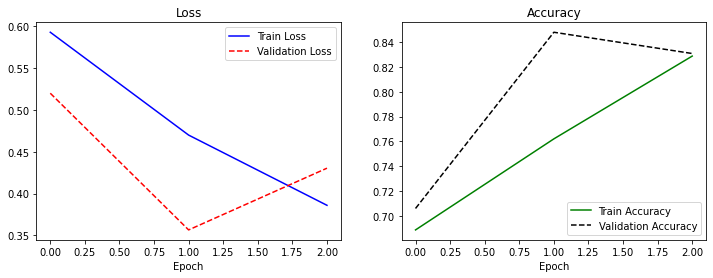

In [269]:
tf_keras_model_history = {'Train Loss': train_history.history['loss'],
                          'Validation Loss': train_history.history['val_loss'],
                          'Train Accuracy': train_history.history['acc'],
                          'Validation Accuracy': train_history.history['val_acc']}

tf_keras_model_history_df = pd.DataFrame(tf_keras_model_history)
tf_keras_model_history_df = tf_keras_model_history_df.round(4)
tf_keras_model_history_df['Epoch'] = tf_keras_model_history_df.reset_index().index + 1
tf_keras_model_history_df = tf_keras_model_history_df[['Epoch', 'Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy']]
tf_keras_model_history_df.to_csv("distilbert-base-uncased_mrpc/tf_keras_model_history.csv", index = False)
display(tf_keras_model_history_df)
print("\n" * 4)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_history.history['loss'], 'b-', label='Train Loss')
plt.plot(train_history.history['val_loss'], 'r--', label='Validation Loss')
plt.title("Loss")
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_history.history['acc'], 'g-', label='Train Accuracy')
plt.plot(train_history.history['val_acc'], 'k--', label='Validation Accuracy')
plt.title("Accuracy")
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [222]:
eval_history  = model.evaluate(test_dataset_batch)

108/108 [==============================] - 7s 61ms/step - loss: 0.8775 - acc: 0.7432


In [228]:
print(eval_history.round(4))

[0.8775202631950378, 0.7431883811950684]


In [229]:
pwd

'/content/drive/MyDrive/lms/huggingface_glue_task/transfomers_v4.21.1'

In [232]:
output_eval_file  = 'distilbert-base-uncased_mrpc/eval_results.txt'

with open(output_eval_file, "w") as writer:
    for i, v in enumerate(eval_history.round(4)) :
        if i == 0 :
            writer.write("Loss = %f\t" %(v))
        if i == 1 :
            writer.write("Accuracy = %f\n" %(v))

#파일에 쓴 테스트 결과 확인
!cat distilbert-base-uncased_mrpc/eval_results.txt

Loss = 0.877520	Accuracy = 0.743188


#Huggingface Trainer

In [233]:
#메모리를 비워줍니다.
del model
del train_dataset_batch
del validation_dataset_batch
del test_dataset_batch

In [234]:
pwd

'/content/drive/MyDrive/lms/huggingface_glue_task/transfomers_v4.21.1'

In [241]:
from transformers import Trainer, TrainingArguments
output_dir = 'huggingface_trainer_mrpc'
metric_name = 'accuracy'

training_arguments = TrainingArguments(
    output_dir, # output이 저장될 경로
    evaluation_strategy="epoch", #evaluation하는 빈도
    learning_rate = 2e-5, #learning_rate
    per_device_train_batch_size = 16, # 각 device 당 batch size
    per_device_eval_batch_size = 16, # evaluation 시에 batch size
    num_train_epochs = 3, # train 시킬 총 epochs
    weight_decay = 0.01, # weight decay
    optim="adamw_torch",
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Trainer를 사용하기 위해서는 TrainingArguments를 통해 학습 관련 설정을 미리 지정한다.

FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version.
<br/>Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning

FutureWarning을 해결하기 위해 TrainingArguments에 optim="adamw_torch"를 지정한다.

In [242]:
from datasets import load_metric
metric = load_metric('glue', 'mrpc')

In [243]:
def compute_metrics(eval_pred):    
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

Trainer의 인자로 넘겨주어야 할 것 중에 compute_metrics 메소드가 있다.
<br/>task가 classification인지 regression인지에 따라 모델의 출력 형태가 달라지므로
<br/>task별로 적합한 출력 형식을 고려해 모델의 성능을 계산하는 방법을 미리 지정한다.

In [244]:
trainer = Trainer(
    model=huggingface_model,                           # 학습시킬 model
    args=training_arguments,                  # TrainingArguments을 통해 설정한 arguments
    train_dataset=encoded_dataset['train'],    # training dataset
    eval_dataset=encoded_dataset['validation'],       # evaluation dataset
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py

In [245]:
train_history = trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence2, idx, sentence1. If sentence2, idx, sentence1 are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 3668
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 690


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_history.history['loss'], 'b-', label='Train Loss')
plt.plot(train_history.history['val_loss'], 'r--', label='Validation Loss')
plt.title("Loss")
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_history.history['acc'], 'g-', label='Train Accuracy')
plt.plot(train_history.history['val_acc'], 'k--', label='Validation Accuracy')
plt.title("Accuracy")
plt.xlabel('Epoch')
plt.legend()

plt.show()

Trainer에 model, arguments, train_dataset, eval_dataset, compute_metrics를 넣고 train을 진행한다.

In [ ]:
eval_history = trainer.evaluate(encoded_dataset['test']

#최종 모델

#결론

#참고문헌